In [52]:
import json
import torch
import torch.nn as nn
from torch.utils.data import RandomSampler
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
import os
import time

from utils import load_im
from utils import save_im
from models.vae import VAE

batch_size = 64
learning_rate = 1e-3
data_path = 'data/omniglot'
intermediate_path = 'saved_models/intermediate'
num_samples = -1

model_name = 'conv_vae_omniglot'
resume_epoch = 148
num_epochs = resume_epoch + 51

torch.cuda.is_available()

True

In [53]:
def save_model_checkpoint(model, name, epoch):
    torch.save(model.state_dict(), f'{intermediate_path}/{name}_epoch{epoch}.pth')

def show_dataset_samples(dataset):
    w, h = 10, 10
    columns, rows = 4, 5
    fig = plt.figure(figsize=(8, 8))
    for i in range(1, columns*rows +1):
        im = np.reshape(dataset[np.random.randint(len(dataset))][0], (64, 64))
        fig.add_subplot(rows, columns, i)
        plt.imshow(im)
    plt.show()

def load_dataset(data_path, num_samples=5000, batch_size=64):
    print(f'Loading data from {data_path}...')
    train_dataset = datasets.ImageFolder(
        root=data_path,
        transform= transforms.Compose([
            transforms.Grayscale(), 
            transforms.RandomAffine(degrees=(-180.0, 180.0), translate=(0.5, 0.5), scale=(0.25, 2.0)),
            transforms.Resize((64, 64)), 
            transforms.ToTensor()
        ])
    )
    use_full = num_samples < 1
    num_samples = len(train_dataset) if use_full else num_samples
    sampler = RandomSampler(train_dataset) if use_full else RandomSampler(train_dataset, replacement=True, num_samples=num_samples)
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=0,
        sampler=sampler
    )
    train_dataset_size_full = len(train_dataset.samples)
    print(f'{train_dataset_size_full} samples found. Sampling {num_samples} for training.')

    return train_loader

def loss_function(recon_x, x, mu, logsigma):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')   # reconstruction loss
    KLD = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())       # KL divergence
    return BCE + KLD, BCE, KLD

def train(model, train_loader, num_epochs=5, learning_rate=1e-3):
    num_samples = len(train_loader.dataset)
    batch_size = train_loader.batch_size
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    outputs = []
    for epoch in range(resume_epoch, num_epochs):
        train_loss, bce_sum, kld_sum = 0, 0, 0
        for i, batch in enumerate(train_loader, 0):
            optimizer.zero_grad()
            x = batch[0].cuda()
            recon_batch, mu, logsigma = model(x)
            loss, bce, kld = loss_function(recon_batch, x, mu, logsigma)
            loss.backward()
            train_loss += loss.item()
            bce_sum += bce
            kld_sum += kld
            optimizer.step()

            # progress
            pct = (i*batch_size/num_samples)*100.0
            print('\r[ %.2f%% ]' % round(pct, 2), end='', flush=True)

        train_loss_mean = train_loss/float(num_samples)
        bce_mean = bce_sum/float(num_samples)
        kld_mean = kld_sum/float(num_samples)

        print('\nEpoch:{}, Loss:{:.4f}, BCE:{:.4f}, KLD:{:.4f}'.format(epoch+1, train_loss_mean, bce_mean, kld_mean))
        outputs.append((epoch, x, recon_batch),)

        # save checkpoint
        save_model_checkpoint(model, model_name, epoch)

    print('Finished!')
    save_model_checkpoint(model, model_name, epoch)
    return outputs

def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight, gain=1.0)
        m.bias.data.fill_(0.01)

Loading data from data/omniglot...
33986 samples found. Sampling 33986 for training.


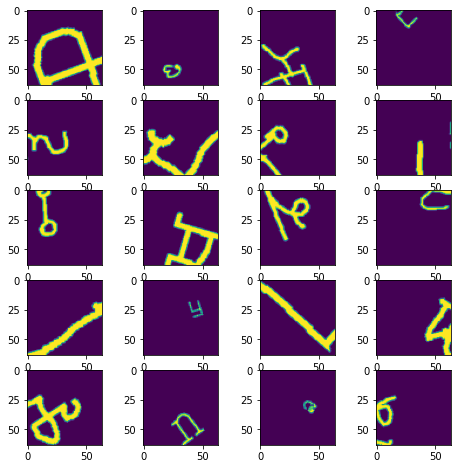

[ 99.99% ]
Epoch:149, Loss:736.8398, BCE:714.8688, KLD:21.9713
[ 99.99% ]
Epoch:150, Loss:496.6560, BCE:460.7110, KLD:35.9452
[ 99.99% ]
Epoch:151, Loss:435.1592, BCE:395.7477, KLD:39.4116
[ 99.99% ]
Epoch:152, Loss:406.6878, BCE:365.9670, KLD:40.7208
[ 99.99% ]
Epoch:153, Loss:391.3377, BCE:349.3987, KLD:41.9389
[ 99.99% ]
Epoch:154, Loss:376.0704, BCE:333.8943, KLD:42.1759
[ 99.99% ]
Epoch:155, Loss:366.8400, BCE:324.5020, KLD:42.3377
[ 99.99% ]
Epoch:156, Loss:358.4321, BCE:316.1456, KLD:42.2865
[ 99.99% ]
Epoch:157, Loss:354.0179, BCE:311.4206, KLD:42.5972
[ 99.99% ]
Epoch:158, Loss:349.1211, BCE:306.6618, KLD:42.4593
[ 99.99% ]
Epoch:159, Loss:343.1669, BCE:301.0635, KLD:42.1033
[ 99.99% ]
Epoch:160, Loss:343.0580, BCE:300.6253, KLD:42.4325
[ 99.99% ]
Epoch:161, Loss:337.4376, BCE:295.2461, KLD:42.1915
[ 99.99% ]
Epoch:162, Loss:330.9541, BCE:288.9528, KLD:42.0010
[ 99.99% ]
Epoch:163, Loss:330.5343, BCE:288.4084, KLD:42.1259
[ 99.99% ]
Epoch:164, Loss:327.8420, BCE:285.8483, KLD:

In [54]:
# Training
with open('config/creature.json') as f:
    config = json.load(f)
    latent_size = config.get('vae.latent.size')

torch.manual_seed(1)
model = VAE(latent_size)

model_checkpoint_path = f'{intermediate_path}/{model_name}_epoch_{resume_epoch}.pth'
if (os.path.exists(model_checkpoint_path)):
    model.load_state_dict(torch.load(model_checkpoint_path))
else:
    model.apply(init_weights)

model.cuda()

train_loader = load_dataset(data_path, num_samples, batch_size)
show_dataset_samples(train_loader.dataset)

outputs = train(
    model=model, 
    train_loader=train_loader,
    num_epochs=num_epochs, 
    learning_rate=learning_rate
)

Loaded VAE model saved_models/vae/conv_vae_omniglot_final2.pth from disk
loss: 687.1782836914062
bce: 618.548583984375
kld:68.62968444824219


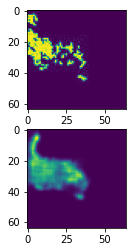

In [101]:
# Inference
with open('config/creature.json') as f:
    config = json.load(f)
    model_path = 'saved_models/vae/conv_vae_omniglot_final.pth'
    latent_size = config.get('vae.latent.size')

model = VAE(latent_size)
model.load_state_dict(torch.load(model_path))
model.cuda()
model.eval()

print(f'Loaded VAE model {model_path} from disk')
#print(model)

im_orig = load_im('data/validate/1594147457.684685.jpg')
im = np.reshape(im_orig, (1, 1, 64, 64))	
im = torch.from_numpy(im).cuda()

im_recon, mu, logsigma = model.cuda().forward(im)
loss, bce, kld = loss_function(im_recon, im, mu, logsigma)
print(f'loss: {loss}\nbce: {bce}\nkld:{kld}')
im_out = np.reshape(im_recon.cpu().detach().numpy(), (64, 64))


fig, ax = plt.subplots(2, 1)
plt.subplot(211)

plt.imshow(im_orig)
plt.subplot(212)
plt.imshow(im_out)
plt.savefig(f'data/validate/out/{time.time()}.png')